In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [6]:
# Extract signal from cropped image, a is the starting point's allowed distance from the baseline, 
# k is the exploration distance of next column
def extract_signal(cropped_img, a, k, baseline, start):
    width, length = cropped_img.shape
    signal = np.full(length, np.nan)

    lower = max(0, baseline-a)
    upper = min(width, baseline+a)
    start_point = np.where(cropped_img[lower:upper]==0)[1][start]
    black0 = lower + np.where(cropped_img[lower:upper,start_point]==0)[0]
    cmin = np.min(black0)
    cmax = np.max(black0)
    signal[start_point] = np.median(black0)

    for col in range(start_point+1,length):
        lower = max(0, cmin-k)
        upper = min(width, cmax+k)
        black = lower + np.where(cropped_img[lower:upper,col]==0)[0]
        if len(black) > 0:
            cmin = np.min(black)
            cmax = np.max(black)
            signal[col] = np.median(black)

    cmin = np.min(black0)
    cmax = np.max(black0)
    
    for col in range(start_point-1,-1,-1):
        lower = max(0, cmin-k)
        upper = min(width, cmax+k)
        black = lower + np.where(cropped_img[lower:upper,col]==0)[0]
        if len(black) > 0:
            cmin = np.min(black)
            cmax = np.max(black)
            signal[col] = np.median(black)
    
    # Missing values interpolation
    missing = np.where(np.isnan(signal))[0]
    interpolation_1 = np.copy(signal)
    interpolation_2 = np.copy(signal)

    for col in missing:
        if col >= 3 and not np.any(np.isnan(interpolation_1[col-3:col])):
            slope = ((interpolation_1[col-1] - interpolation_1[col-2]) +
                     (interpolation_1[col-2] - interpolation_1[col-3])) / 2
            interpolation_1[col] = interpolation_1[col-1] + slope
        
    interpolation_1[np.where(np.isnan(interpolation_1))[0]] = np.inf

    for col in np.flip(missing):
        if col < len(signal)-3 and not np.any(np.isnan(interpolation_1[col+1:col+4])):
            slope = ((interpolation_2[col+1] - interpolation_2[col+2]) +
                     (interpolation_2[col+2] - interpolation_2[col+3])) / 2
            interpolation_2[col] = interpolation_2[col+1] + slope
    
    interpolation_2[np.where(np.isnan(interpolation_2))[0]] = np.inf

    interpolations = [interpolation_1, interpolation_2]

    for col in missing:
        choice = np.argmin([np.abs(interpolation_1[col] - baseline), np.abs(interpolation_2[col] - baseline)])
        signal[col] = interpolations[choice][col]

    #signal = signal - baseline

    return signal

In [2]:
lead_names = ['lead_I', 'lead_II', 'lead_III', 'lead_aVR', 'lead_aVL', 'lead_aVF', 
              'lead_V1', 'lead_V2', 'lead_V3', 'lead_V4', 'lead_V5', 'lead_V6']

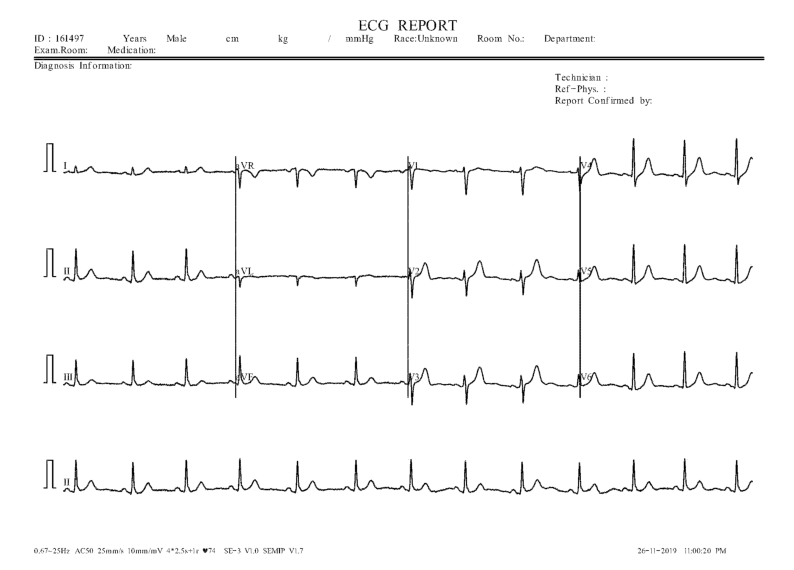

In [4]:
path = 'ECG/Normal/Normal (1).jpg'
img = cv2.imread(path, 2)
# Binarize image
th, bw_img = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10,10))
plt.axis("off")
# convert color from CV2 BGR back to RGB
image = cv2.cvtColor(bw_img, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [5]:
# Find isoelectric lines
h_proj = np.sum(bw_img==0, axis=1)

ie1 = 400 + np.argmax(h_proj[400:500])
ie2 = 700 + np.argmax(h_proj[700:800])
ie3 = 1000 + np.argmax(h_proj[1000:1100])

s1 = 200
s2 = 700
s3 = 1200
s4 = 1700

# Separate lead signals by cropping the image
lead_I = bw_img[ie1-160:ie1+160,s1:s1+400]
lead_II = bw_img[ie2-160:ie2+160,s1:s1+400]
lead_III = bw_img[ie3-160:ie3+160,s1:s1+400]
lead_aVR = bw_img[ie1-160:ie1+160,s2:s2+400]
lead_aVL = bw_img[ie2-160:ie2+160,s2:s2+400]
lead_aVF = bw_img[ie3-160:ie3+160,s2:s2+400]
lead_V1 = bw_img[ie1-160:ie1+160,s3:s3+400]
lead_V2 = bw_img[ie2-160:ie2+160,s3:s3+400]
lead_V3 = bw_img[ie3-160:ie3+160,s3:s3+400]
lead_V4 = bw_img[ie1-160:ie1+160,s4:s4+400]
lead_V5 = bw_img[ie2-160:ie2+160,s4:s4+400]
lead_V6 = bw_img[ie3-160:ie3+160,s4:s4+400]

leads = [lead_I, lead_II, lead_III, lead_aVR, lead_aVL, lead_aVF, lead_V1, lead_V2, lead_V3, lead_V4, lead_V5, lead_V6]

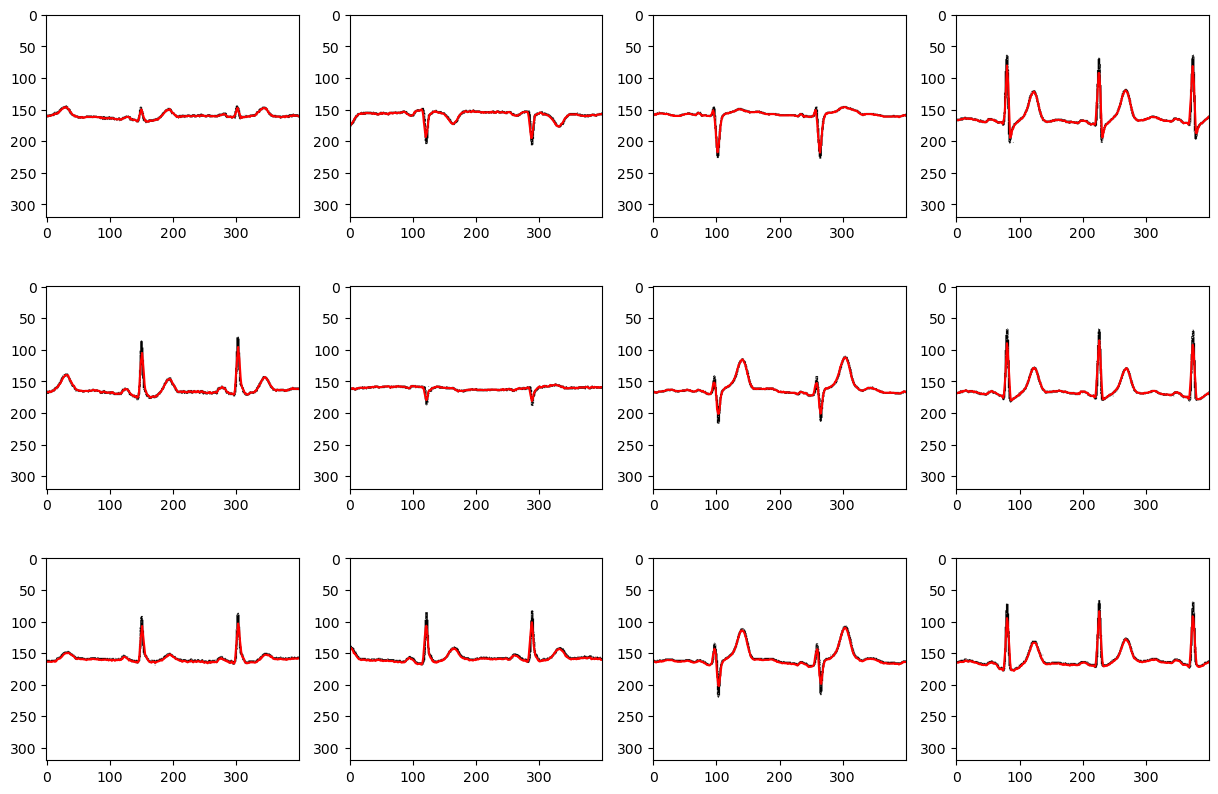

In [7]:
# Plot the extracted signals on top of the cropped images
sigs = np.full((12,400), np.nan)
figure, axes = plt.subplots(3, 4, figsize=(15, 10))
for i in range(12):
    lead = leads[i]
    signal = extract_signal(lead, a=10, k=30, baseline=160, start=0)
    axes[i%3,i//3].imshow(cv2.cvtColor(lead, cv2.COLOR_BGR2RGB))
    axes[i%3,i//3].plot(signal, c='r')
    sigs[i] = (signal - 160) * 0.5 / 80